In [1]:
import glob
import numpy as np
import scipy.io
%matplotlib inline
import matplotlib.pyplot as plt
import mdshare
import pyemma
from tqdm.notebook import tqdm
from matplotlib import rc
from scipy.ndimage import gaussian_filter
from scipy.signal import savgol_filter
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
#from scipy.stats import gaussian_kde

import seaborn as sns


In [2]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.serif": ["computer modern roman"],
    "font.size": 12})
plw = 0.6
pcs = 3
pms = 3
bfillc = [0.9,0.9,0.9]
plt.rcParams['axes.linewidth'] = plw
plt.rcParams['xtick.top'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = plw
plt.rcParams['xtick.minor.width'] = plw
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.major.size'] = 4.5
plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.major.width'] = plw
plt.rcParams['ytick.minor.width'] = plw
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.major.size'] = 5
plt.rcParams["figure.figsize"] = (5,4)

nn=np.linspace(-1,3)

##  Functions

In [3]:
def get_histogram(
        xall, yall, nbins=100,
        weights=None, avoid_zero_count=False):
    z, xedge, yedge = np.histogram2d(
        xall, yall, bins=nbins, weights=weights)
    x = 0.5 * (xedge[:-1] + xedge[1:])
    y = 0.5 * (yedge[:-1] + yedge[1:])
    if avoid_zero_count:
        z = _np.maximum(z, _np.min(z[z.nonzero()]))
    return x, y, z.T # transpose to match x/y-directions

def _to_density(z):
    return z / float(z.sum())

def _to_free_energy(z, minener_zero=False):
    pi = _to_density(z)
    free_energy = np.inf * np.ones(shape=z.shape)
    nonzero = pi.nonzero()
    free_energy[nonzero] = -np.log(pi[nonzero])
    if minener_zero:
        free_energy[nonzero] -= np.min(free_energy[nonzero])
    return free_energy

def plot_map(
        x, y, z, ax=None, cmap=None,
        ncontours=100, vmin=None, vmax=None, levels=None,
        cbar=True, cax=None, cbar_label=None,
        cbar_orientation='vertical', norm=None,
        **kwargs):

    import matplotlib.pyplot as _plt
    if ax is None:
        fig, ax = _plt.subplots()
    else:
        fig = ax.get_figure()
    mappable = ax.contourf(
        x, y, z, ncontours, norm=norm,
        vmin=vmin, vmax=vmax, cmap=cmap,
        levels=levels)
    misc = dict(mappable=mappable)
    if cbar_orientation not in ('horizontal', 'vertical'):
        raise ValueError(
            'cbar_orientation must be "horizontal" or "vertical"')
    if cbar:
        if cax is None:
            cbar_ = fig.colorbar(
                mappable, ax=ax, orientation=cbar_orientation)
        else:
            cbar_ = fig.colorbar(
                mappable, cax=cax, orientation=cbar_orientation)
        if cbar_label is not None:
            cbar_.set_label(cbar_label)
        misc.update(cbar=cbar_)
    return fig, ax, misc

# Load Data

In [4]:
data = []
lendata = []

#Loop through the directories containing the paths
for directory in glob.glob("./run*",recursive=True):
    print("Directory",directory)
    #Loop through the paths
    pathname=directory+"/CVscreeningeneptm.dat"
    print(directory,pathname)
    for file in glob.glob(pathname):      
        inp = np.loadtxt(file, skiprows=3,usecols=np.arange(1,18))
        data.append(inp)
        lendata.append(len(inp))

# Data concatenated
Data = np.concatenate(data)
#Data = np.delete(Data,0,1)

numCVs = Data.shape[1]
datalabels = ["cn.mean","ncl","ncs","Q4.mean","q4.mean","ncnq4","laQ4.mean","Q6.mean","q6.mean","ncnq6","laQ6.mean","ent","nclust1", "ene", "non", "fcc", "hcp"]
npdatalabels = np.array(["cn.mean","ncl","ncs","Q4.mean","q4.mean","ncnq4","laQ4.mean","Q6.mean","q6.mean","ncnq6","laQ6.mean","ent","nclust1", "ene", "non", "fcc", "hcp"])


Directory ./run38N
./run38N ./run38N/CVscreeningeneptm.dat
Directory ./run39Y
./run39Y ./run39Y/CVscreeningeneptm.dat
Directory ./run99Y
./run99Y ./run99Y/CVscreeningeneptm.dat
Directory ./run612N
./run612N ./run612N/CVscreeningeneptm.dat
Directory ./run525Y
./run525Y ./run525Y/CVscreeningeneptm.dat
Directory ./run725N
./run725N ./run725N/CVscreeningeneptm.dat
Directory ./run733Y
./run733Y ./run733Y/CVscreeningeneptm.dat
Directory ./run17N
./run17N ./run17N/CVscreeningeneptm.dat
Directory ./run178Y
./run178Y ./run178Y/CVscreeningeneptm.dat
Directory ./run1005new
./run1005new ./run1005new/CVscreeningeneptm.dat
Directory ./run287Y
./run287Y ./run287Y/CVscreeningeneptm.dat
Directory ./run1006new
./run1006new ./run1006new/CVscreeningeneptm.dat
Directory ./run1007new
./run1007new ./run1007new/CVscreeningeneptm.dat
Directory ./run1008new
./run1008new ./run1008new/CVscreeningeneptm.dat
Directory ./run1002new-crystal
./run1002new-crystal ./run1002new-crystal/CVscreeningeneptm.dat


### Plot the time series

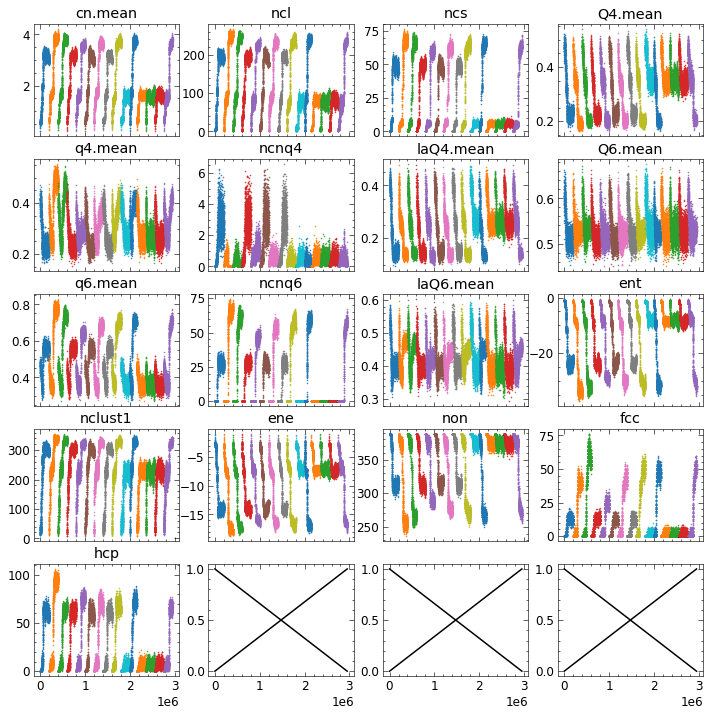

In [5]:
panels = int(np.sqrt(numCVs))+1
figure, axis = plt.subplots(panels, panels-1, figsize=(12,12), sharex=True)

cols = ['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14','C15','C16','C17','C18','C19','C20','C1']
c = 0
xax = np.arange(0,Data.shape[0])

for i in range(0,panels):
    for j in range(0,panels-1):           
        
        if c < numCVs:
            tf = 0
                
            for traj in range(0,len(lendata)):
                t0 = tf
                tf += lendata[traj]
                #print(c,traj, lendata[traj],t0,tf)

                axis[i, j].plot(xax[t0:tf:100],Data[t0:tf:100,c],'o',markersize=0.5)
                axis[i, j].set_title(format(datalabels[c]))              

        else:
            axis[i, j].plot([0,Data.shape[0]],[1,0],'k-')
            axis[i, j].plot([0,Data.shape[0]],[0,1],'k-')
                                     
        c += 1

#plt.show()
#figure.savefig('./CVsTimeseries.png', dpi=300, bbox_inches='tight')

### Select the RC

In [6]:
# The BEST reaction coordinates:
RC = np.full((numCVs, numCVs), 100, dtype=int)

RC[0,0]     = 2
RC[1,0:2]   = [2, 9]
RC[2,0:3]   = [2, 9, 12]
RC[3,0:4]   = [2, 9, 12, 15]
RC[4,0:5]   = [2, 9, 11, 13, 15]
RC[5,0:6]   = [1, 2, 9, 11, 12, 15]
RC[6,0:7]   = [1, 2, 4, 9, 11, 12, 15]
RC[7,0:8]   = [1, 2, 4, 6, 9, 11, 12, 15]
RC[8,0:9]   = [1, 2, 4, 6, 9, 11, 12, 13, 15]
RC[9,0:10]  = [1, 2, 4, 6, 9, 11, 12, 13, 15, 16]
RC[10,0:11] = [1, 2, 4, 5, 6, 9, 11, 12, 13, 15, 16]
RC[11,0:12] = [1, 2, 4, 5, 6, 9, 10, 11, 12, 13, 15, 16]
RC[12,0:13] = [1, 2, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16]
RC[13,0:14] = [1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16]
RC[14,0:15] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16]
RC[15,0:16] = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16]
RC[16,0:17] = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]


In [7]:
CVdim = 17 #number of CVs to use
RC_CVs = RC[CVdim-1,0:CVdim]
npdatalabels[RC_CVs].tolist()

['cn.mean',
 'ncl',
 'ncs',
 'Q4.mean',
 'q4.mean',
 'ncnq4',
 'laQ4.mean',
 'Q6.mean',
 'q6.mean',
 'ncnq6',
 'laQ6.mean',
 'ent',
 'nclust1',
 'ene',
 'non',
 'fcc',
 'hcp']

### Plot Feature Histogram

In [8]:
# Get absolute normalised values

DataNorm = np.zeros(Data[:,RC_CVs].shape)
for i in range(0,DataNorm.shape[1]):
    print(datalabels[RC_CVs[i]],np.amin(Data[:,RC_CVs[i]]),np.amax(Data[:,RC_CVs[i]]))
    DataNorm[:,i] = np.abs(Data[:,RC_CVs[i]])/np.amax(np.abs(Data[:,RC_CVs[i]]))

    
# We can't use concatenated data for clustering, so build a list from DataNorm
normdata = []
tf = 0
#maxvals = np.amax(np.abs(Data[:,RC_CVs]),axis=0)
for i in range(0,len(data)):
    #normdata.append(abs(data[i])/maxvals)
    #normdata.append(abs(data[i][:][RC_CVs])/maxvals)
    
    t0 = tf
    tf += lendata[i]
    normdata.append(DataNorm[t0:tf])


cn.mean 0.142608 4.209561
ncl 0.006183 267.382347
ncs 9.7e-05 76.965064
Q4.mean 0.153038 0.562416
q4.mean 0.143395 0.576264
ncnq4 0.0 9.238967
laQ4.mean 0.092013 0.508012
Q6.mean 0.404036 0.70567
q6.mean 0.253202 0.849934
ncnq6 1.3e-05 75.38844
laQ6.mean 0.27969 0.628271
ent -37.697048 -0.39205
nclust1 5.0 357.0
ene -18.919509 -0.67177002
non 234.0 388.0
fcc 0.0 78.0
hcp 0.0 111.0


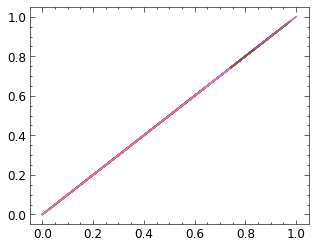

In [9]:
# Check for parity
plt.plot(normdata[-1][:],DataNorm[t0:tf,:])

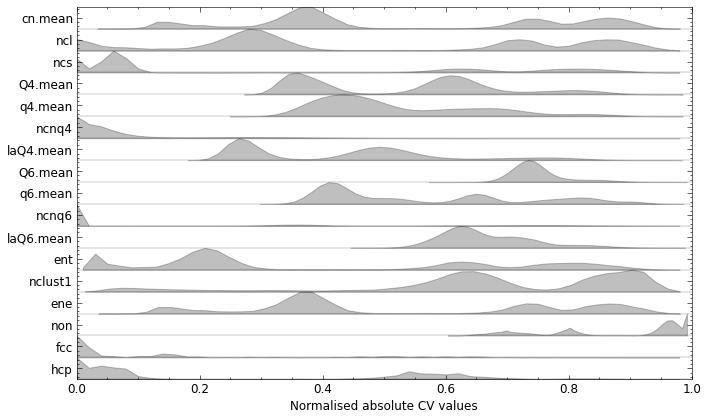

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))
pyemma.plots.plot_feature_histograms(DataNorm,feature_labels=npdatalabels[RC_CVs[:]].tolist(),ax=ax,color='black');
ax.set_xlim(0,1)
ax.set_xlabel('Normalised absolute CV values')
fig.tight_layout()
#plt.savefig('./CVdistnorm.png', dpi=300, bbox_inches='tight')

# Do TICA 

In [11]:
from deeptime.decomposition import TICA
from deeptime.decomposition import VAMP

lagt= 100
tica_estimator = TICA(dim=2, lagtime=lagt).fit(normdata)
#tica_estimator = VAMP(dim=2, lagtime=lagt).fit(normdata)
tica = tica_estimator.fetch_model()

# We can't use concatenated data for clustering, so build a list of tics
tics_f = []
for i in range(0,len(normdata)):
    tics_f.append(tica.transform(normdata[i]))

tics = np.concatenate(tics_f)

<Figure size 288x144 with 0 Axes>

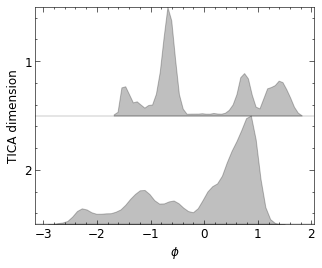

In [12]:
plt.figure(figsize=(4, 2))
pyemma.plots.plot_feature_histograms(tics, color='k')
plt.xlabel(r'$\phi$')
plt.ylabel('TICA dimension')
plt.yticks(ticks=[0.3,1.3], labels=['2', '1'])
plt.savefig('./tics_features.png', dpi=300, bbox_inches='tight')

<Figure size 288x288 with 0 Axes>

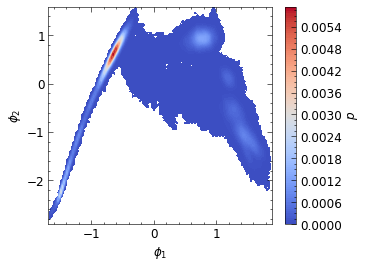

In [13]:
plt.figure(figsize=(4, 4))
pyemma.plots.plot_density(tics[:,0],tics[:,1],cmap='coolwarm',nbins=150,cbar_label='$p$')
plt.xlim(np.amin(tics[:,0]),np.amax(tics[:,0]));
plt.ylim(np.amin(tics[:,1]),np.amax(tics[:,1]));
plt.xlabel(r'$\phi_1$') 
plt.ylabel(r'$\phi_2$')
plt.savefig('./CVS_tics_dens.png', dpi=300, bbox_inches='tight')

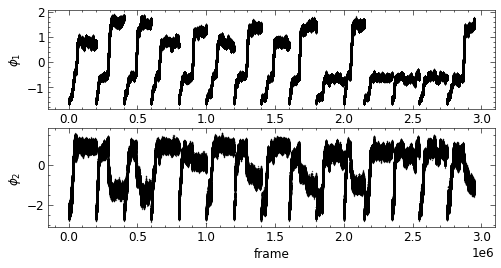

In [14]:
fig, ax = plt.subplots(2, figsize=(8, 4))
ax[0].plot(tics[:,0],'k.',markersize=pms/5)
ax[0].set_xlabel('frame')
ax[0].set_ylabel(r'$\phi_1$')
ax[1].plot(tics[:,1],'k.',markersize=pms/5)
ax[1].set_xlabel('frame')
ax[1].set_ylabel(r'$\phi_2$')
plt.savefig('./tics_traj.png', dpi=300, bbox_inches='tight')

### Check the mapping of states from what we know

Text(0, 0.5, '$\\phi_2$')

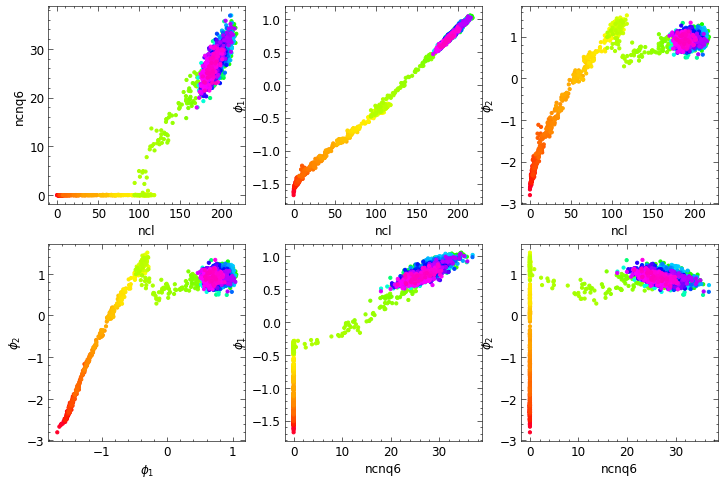

In [15]:
fig, ax = plt.subplots(2,3, figsize=(12, 8))

t0 = 0
tf = 200000
cols = np.arange(0,2000)/2000

ax[0,0].scatter(Data[t0:tf:100,1],Data[t0:tf:100,9],s=10,c=cols,cmap='gist_rainbow')
ax[0,0].set_xlabel('ncl')
ax[0,0].set_ylabel('ncnq6')

ax[1,0].scatter(tics[t0:tf:100,0],tics[t0:tf:100,1],s=10,c=cols,cmap='gist_rainbow')
ax[1,0].set_xlabel(r'$\phi_1$')
ax[1,0].set_ylabel(r'$\phi_2$')

ax[0,1].scatter(Data[t0:tf:100,1],tics[t0:tf:100,0],s=10,c=cols,cmap='gist_rainbow')
ax[0,1].set_xlabel('ncl')
ax[0,1].set_ylabel(r'$\phi_1$')

ax[1,1].scatter(Data[t0:tf:100,9],tics[t0:tf:100,0],s=10,c=cols,cmap='gist_rainbow')
ax[1,1].set_xlabel('ncnq6')
ax[1,1].set_ylabel(r'$\phi_1$')

ax[0,2].scatter(Data[t0:tf:100,1],tics[t0:tf:100,1],s=10,c=cols,cmap='gist_rainbow')
ax[0,2].set_xlabel('ncl')
ax[0,2].set_ylabel(r'$\phi_2$')

ax[1,2].scatter(Data[t0:tf:100,9],tics[t0:tf:100,1],s=10,c=cols,cmap='gist_rainbow')
ax[1,2].set_xlabel('ncnq6')
ax[1,2].set_ylabel(r'$\phi_2$')

### Discretise the TICA space

In [16]:
from deeptime.clustering import KMeans
from deeptime.clustering import RegularSpace

#estimator = KMeans(6, init_strategy='uniform', max_iter=500, progress=tqdm).fit(tics).fetch_model()
#estimator = RegularSpace(dmin=0.15,max_centers=100,n_jobs=4).fit(DataConc).fetch_model()
estimator = RegularSpace(dmin=0.22).fit(tics_f).fetch_model()
print("Number of states:",estimator.cluster_centers.shape[0])


# We can't use concatenated data for clustering, so build a list of tics
dtraj_f = []
for i in range(0,len(normdata)):
    dtraj_f.append(estimator.transform(tics_f[i]))

dtraj = np.concatenate(dtraj_f)
    


Number of states: 105


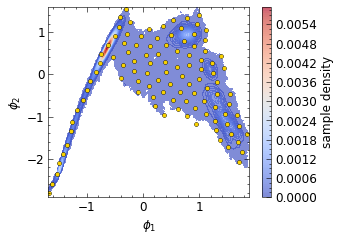

In [17]:
fig, ax = plt.subplots(figsize=(4.5,3.5))
pyemma.plots.plot_density(*tics.T, ax=ax, cbar=True, alpha=0.65, cmap='coolwarm',nbins=150);
ax.scatter(*estimator.cluster_centers.T, s=12, c='black')
plt.scatter(*estimator.cluster_centers.T, s=8, c='gold')
ax.set_xlabel(r'$\phi_1$')
ax.set_ylabel(r'$\phi_2$')
ax.set_xlim(np.amin(tics[:,0]),np.amax(tics[:,0]))
ax.set_ylim(np.amin(tics[:,1]),np.amax(tics[:,1]))
plt.savefig('./CVScluster_features.png', dpi=300, bbox_inches='tight')

### Plot the TICA trajectory

Text(0, 0.5, 'partition')

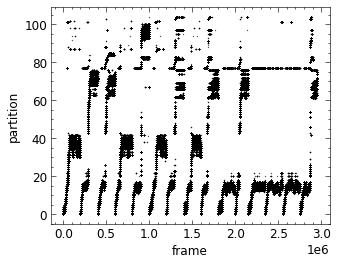

In [18]:
plt.plot(dtraj,'k.',markersize=pms/5)
plt.xlabel('frame')
plt.ylabel('partition')

### Assignment to partitions

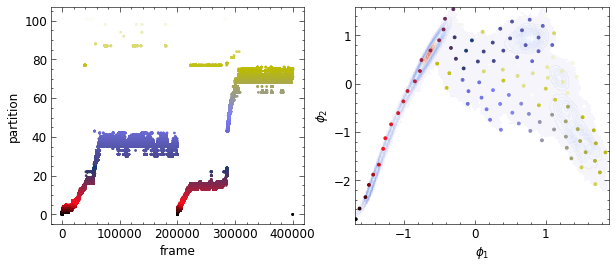

In [19]:
x = np.arange(0,400000)
cols = np.arange(0,estimator.cluster_centers.shape[0])

fig, ax = plt.subplots(1,2, figsize=(10, 4))

ax[0].scatter(x,dtraj[0:400000],s=3,c=dtraj[0:400000],cmap='gist_stern')
ax[0].set_xlabel('frame')
ax[0].set_ylabel('partition')

pyemma.plots.plot_density(tics[:,0],tics[:,1],cbar=False, ax=ax[1], alpha=0.05,cmap='coolwarm',nbins=150)
ax[1].scatter(*estimator.cluster_centers.T, s=8, c=cols,cmap='gist_stern')
ax[1].set_xlabel(r'$\phi_1$')
ax[1].set_ylabel(r'$\phi_2$')

ax[1].set_xlim(np.amin(tics[:,0]),np.amax(tics[:,0]));
ax[1].set_ylim(np.amin(tics[:,1]),np.amax(tics[:,1]));


In [20]:
# Barrier to crystallisation when n=17
#estimator.cluster_centers[23]
#print(np.argwhere(dtraj[0:200000] == 23).T)


### Calculate the TICA VAMP-2 score

1 [1.932967607754361] [0.006458331586047884]
5 [1.9338966016196977] [0.006665388967047542]
10 [1.9345873990422224] [0.00648665557676811]
20 [1.9325531629020745] [0.007892688733796773]
30 [1.9336050895509005] [0.007817757978105295]
50 [1.933975794594882] [0.006269046887562215]
75 [1.9355486819363676] [0.006732282310532782]
100 [1.9375460473044424] [0.005400597140562983]
150 [1.9360431469876627] [0.006290662788501571]
200 [1.9360487395331887] [0.007833832197488082]
250 [1.9376606558343805] [0.005170866835408221]


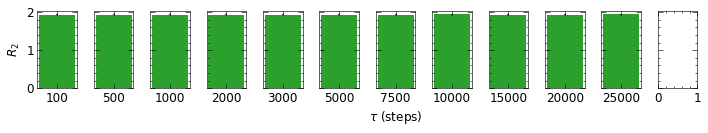

In [21]:
from deeptime.decomposition import vamp_score_cv

#lags = [1,5,10,20,30,50,75,100, 200, 500, 1000, 5000, 10000] 
lags = [1,5,10,20,30,50,75,100, 150, 200, 250] 
fig, axes = plt.subplots(1, 12, figsize=(10, 2), sharey=True)
labels = ['TICA']

for ax, lag in zip(axes.flat, lags):
    estimator.lagtime = lag
    scores = vamp_score_cv(tica_estimator, trajs=dtraj_f, blocksplit=True, blocksize=10000)
    means = [scores.mean()]
    errors = [scores.std()]
    ax.bar('{}'.format(lag*100), means, yerr=errors, color='C2')
    print(lag,means,errors)
    
    #ax.bar(lag, means, yerr=errors, color=['C2', 'C3', 'C4'])
    #ax.set_title(r'$\tau$={}'.format(lag))

#plt.xticks(rotation=30, ha='right')
axes[0].set_ylabel(r'$R_2$')
axes[6].set_xlabel(r'$\tau$ (steps)')
fig.tight_layout()
plt.savefig('ticavamp2.png', dpi=300, bbox_inches='tight')

### Build a Max Liklihood MSM - deeptime

  0%|          | 0/11 [00:00<?, ?it/s]

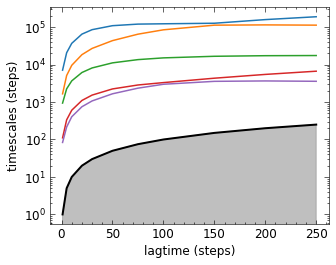

In [22]:
from deeptime.markov.msm import BayesianMSM
from deeptime.markov.msm import MaximumLikelihoodMSM
from deeptime.util.validation import implied_timescales
from deeptime.plots import plot_implied_timescales

models = []
for lag in tqdm(lags, leave=False):
    #models.append(BayesianMSM(lagtime=lag).fit_fetch(dtraj)) # NOT WORKING!!!!
    models.append(MaximumLikelihoodMSM(lagtime=lag).fit_fetch(dtraj_f))    

its = implied_timescales(models)
#its = its_bayesian_msm(dtraj, [1000])

ax = plot_implied_timescales(its, n_its=5)
ax.set_yscale('log')
ax.set_xlabel('lagtime (steps)')
ax.set_ylabel('timescales (steps)');



### Build a Bayesian MSM - PyEMMA

In [23]:
its = pyemma.msm.its(dtraj_f, lags=lags, nits=12, errors='bayes')

estimating BayesianMSM:   0%|                                                                                 …

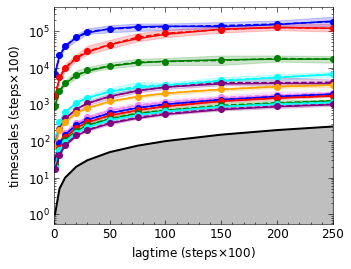

In [24]:
plt.figure(figsize=(5, 4))
pyemma.plots.plot_implied_timescales(its, ylog=True);
plt.xlabel(r'lagtime (steps$\times 100$)')
plt.ylabel(r'timescales (steps$\times 100$)');
plt.xlim(0,lags[-1])
plt.savefig('ticaBayesMSM.png', dpi=300, bbox_inches='tight')

In [25]:
bayesian_msm = pyemma.msm.bayesian_markov_model(dtraj_f, lag=lagt, conf=0.95, count_mode='effective', dt_traj='100 ps',mincount_connectivity=1E-5)
sample_mean = bayesian_msm.sample_mean('timescales', k=1)
sample_conf_l, sample_conf_r = bayesian_msm.sample_conf('timescales', k=1)

print('MSM number of states:',bayesian_msm.nstates)
print('Mean of first ITS: {:f}'.format(sample_mean[0]))
print('Confidence interval: [{:f}, {:f}]'.format(sample_conf_l[0], sample_conf_r[0]))

pyemma.msm.estimators.bayesian_msm.BayesianMSM[2]: compute stat. inefficiencies:   0%|                        …

pyemma.msm.estimators.bayesian_msm.BayesianMSM[2]: Sampling MSMs:   0%|                                       …

MSM number of states: 105
Mean of first ITS: 13382629.684464
Confidence interval: [10516404.166130, 16790948.988713]


### Slowest Rate

In [26]:
lx = 92.831777
Vol = lx**3

ncrt = sample_mean[0]
J = 1/(ncrt*Vol)

ncrt_u = sample_conf_l[0]
J_l = 1/(ncrt_u*Vol)

ncrt_l = sample_conf_r[0]
J_u = 1/(ncrt_l*Vol)

print('Slowest Rate:',J)
print('Confidence interval:',J_u,' ' ,J_l)

Slowest Rate: 9.340466083520765e-14
Confidence interval: 7.444486833953378e-14   1.1886191962708863e-13


### Check the states are all being used

In [27]:
from deeptime.markov import TransitionCountEstimator

counts_estimator = TransitionCountEstimator(lagtime=lagt, count_mode='sliding')
counts = counts_estimator.fit_fetch(dtraj_f).submodel_largest()

msm_estimator = MaximumLikelihoodMSM()
msm = msm_estimator.fit_fetch(counts)

print(f'fraction of states used = {msm.state_fraction}')
print(f'fraction of counts used = {msm.count_fraction}')
msm.timescales(k=4)

fraction of states used = 1.0
fraction of counts used = 1.0


array([122774.0231463 ,  84751.25971756,  15097.52892711,   3304.33491216])

### C-K test

estimating BayesianMSM:   0%|                                                                                 …

/home/aaron/Packages/anaconda3/envs/workshop/lib/python3.9/site-packages/msmtools/analysis/api.py:367: UserWarning: truncated eigendecomposition to contain 104 components
  warnings.warn('truncated eigendecomposition to contain %s components' % new_k, category=UserWarning)


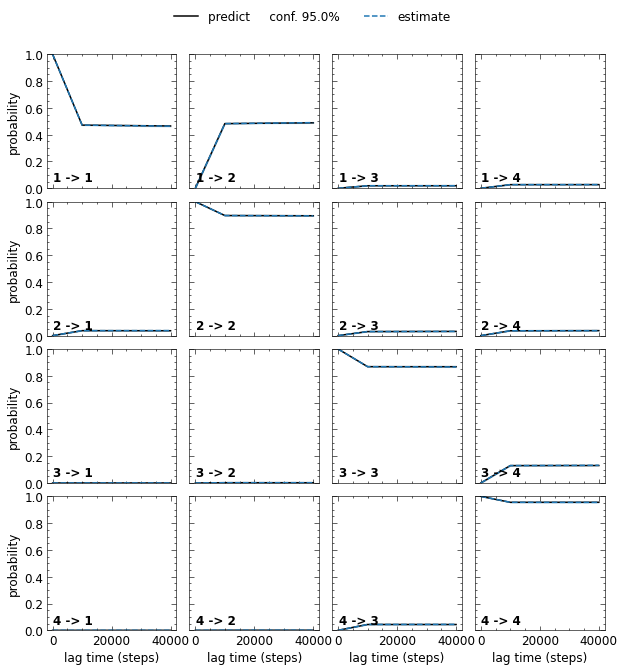

In [28]:
nstates = 4
cktest = bayesian_msm.cktest(nstates, mlags=5)
pyemma.plots.plot_cktest(cktest, dt=100, units=r'steps');
plt.savefig('ticaCK.png', dpi=300, bbox_inches='tight')

### Stationary distribution

<Figure size 288x288 with 0 Axes>

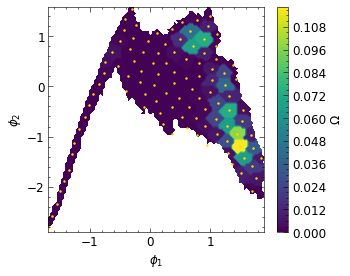

In [29]:
plt.figure(figsize=(4, 4))
fig, ax, misc = pyemma.plots.plot_contour(
    *tics.T, bayesian_msm.stationary_distribution[dtraj],
    cbar_label='$\Omega$',
    method='nearest', mask=True)
ax.scatter(*estimator.cluster_centers.T, s=2, c='gold')
plt.xlabel(r'$\phi_1$')
plt.ylabel(r'$\phi_2$')
plt.xlim(np.amin(tics[:,0]),np.amax(tics[:,0]));
plt.ylim(np.amin(tics[:,1]),np.amax(tics[:,1]));
#ax.set_aspect('equal')
fig.set_figheight(4)
fig.set_figwidth(5)
fig.tight_layout()
plt.savefig('ticaStationary.png', dpi=300, bbox_inches='tight')



### Free Energy

0 (87, 40) 1.4419770266098415 -1.088286738873252 0.0
0 77 97 30 50
1 (68, 85) 0.7625355493763109 0.9384328676073339 0.3364361959018609
1 58 78 75 95
2 (83, 52) 1.298936715613309 -0.5478281771450957 0.5553899475893047
2 73 93 42 62
3 (80, 67) 1.1916564823659095 0.12774502501509954 0.7116028566012425
3 70 90 57 77
4 (90, 29) 1.5492572598572412 -1.583707087124062 1.4666988611578615
4 80 100 19 39
5 (29, 79) -0.6321074828398833 0.6682035867432556 2.499841264397003
5 19 39 69 89


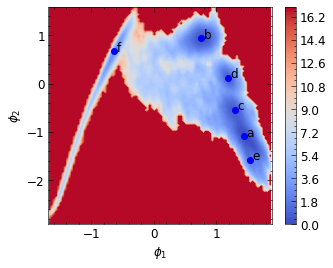

In [30]:
# Probability density
x, y, z = get_histogram(
    *tics.T,
    weights=np.concatenate(bayesian_msm.trajectory_weights()),
    nbins=100,
    )

# Free energy
kT = 1.
f = _to_free_energy(z, minener_zero=True) * kT

fmax = np.amax(f[f != np.inf])
f[f == np.inf] = fmax # replace inf

# Plot
plot_map(x, y, f,
         cmap='coolwarm',
         ncontours=100,
         cbar=True,
         cbar_orientation='vertical')

xyc = 10
minxy = []
labels = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']
f = f.astype(object)
for i in range(0,6):
    # Get the minimum FE
    pmin = np.unravel_index(f.T.argmin(), f.T.shape)

    plt.plot(x[pmin[0]],y[pmin[1]],'ob')
    plt.text(x[pmin[0]+1],y[pmin[1]],labels[i])
    print(i,pmin,x[pmin[0]],y[pmin[1]],f.T[pmin])
    minxy.append([x[pmin[0]],y[pmin[1]]])
    
    # Remove this point
    minimx = np.abs(pmin[0]-xyc)
    maximx = np.abs(pmin[0]+xyc)
    minimy = np.abs(pmin[1]-xyc)
    maximy = np.abs(pmin[1]+xyc)
    f.T[minimx:maximx,minimy:maximy] = 100

    print(i,pmin[0]-xyc,pmin[0]+xyc,pmin[1]-xyc,pmin[1]+xyc)
    
plt.xlabel(r'$\phi_1$')
plt.ylabel(r'$\phi_2$')
plt.xlim(np.amin(tics[:,0]),np.amax(tics[:,0]));
plt.ylim(np.amin(tics[:,1]),np.amax(tics[:,1]));
plt.savefig('ticaFE-minima.png', dpi=300, bbox_inches='tight',transparent=True)



0 (87, 40) 1.4419770266098415 -1.088286738873252 0.0
0 67 107 20 60
1 (68, 85) 0.7625355493763109 0.9384328676073339 0.3364361959018609
1 48 88 65 105
2 (81, 64) 1.2274165601150426 -0.00736961541693959 1.1768418870832695
2 61 101 44 84
3 (29, 79) -0.6321074828398833 0.6682035867432556 2.499841264397003
3 9 49 59 99


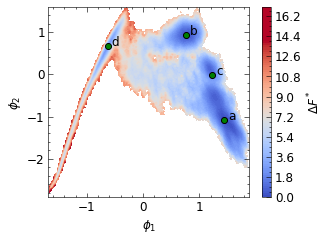

In [31]:
f = _to_free_energy(z, minener_zero=True) * kT
fmax = np.amax(f[f != np.inf])
f[f == np.inf] = fmax # replace inf

fig, ax, misc = pyemma.plots.plot_free_energy(
    *tics.T,
    weights=np.concatenate(bayesian_msm.trajectory_weights()),
    legacy=False,
    nbins=150,
    #cmap='viridis',
    cbar_label='$\Delta F^*$',
    minener_zero=True,
    vmax=14,
    cmap='coolwarm')

xyc = 20
minxy = []
labels = ['a', 'b', 'c', 'd']
f = f.astype(object)
for i in range(0,4):
    # Get the minimum FE
    pmin = np.unravel_index(f.T.argmin(), f.T.shape)

    plt.plot(x[pmin[0]],y[pmin[1]],'ok',markersize=6)
    plt.plot(x[pmin[0]],y[pmin[1]],'og',markersize=4)    
    plt.text(x[pmin[0]+2],y[pmin[1]],labels[i])
    print(i,pmin,x[pmin[0]],y[pmin[1]],f.T[pmin])
    minxy.append([x[pmin[0]],y[pmin[1]]])
    
    # Remove this point
    minimx = np.abs(pmin[0]-xyc)
    maximx = np.abs(pmin[0]+xyc)
    minimy = np.abs(pmin[1]-xyc)
    maximy = np.abs(pmin[1]+xyc)
    f.T[minimx:maximx,minimy:maximy] = 100

    print(i,pmin[0]-xyc,pmin[0]+xyc,pmin[1]-xyc,pmin[1]+xyc)

plt.xlabel(r'$\phi_1$')
plt.ylabel(r'$\phi_2$')
plt.xlim(np.amin(tics[:,0]),np.amax(tics[:,0]));
plt.ylim(np.amin(tics[:,1]),np.amax(tics[:,1]));
fig.set_figheight(3.5)
fig.set_figwidth(4.5)
plt.savefig('ticaFE.png', dpi=300, bbox_inches='tight')

### Comittor Analysis

In [32]:
posA = np.array(minxy[0])
posB = np.array(minxy[1])

A = [np.argmin(np.sum(np.abs(estimator.cluster_centers-posA),axis=1))]
B = [np.argmin(np.sum(np.abs(estimator.cluster_centers-posB),axis=1))]

/tmp/ipykernel_8392/466173573.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(posA[0],posA[1],'ok',color='gold',markersize=5)
/tmp/ipykernel_8392/466173573.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(posB[0],posB[1],'ok',color='gold',markersize=5)


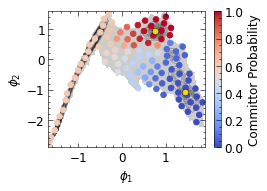

In [33]:
tpt = pyemma.msm.tpt(bayesian_msm, A, B)
fig, ax = plt.subplots(figsize=(3.5,2.5))
pyemma.plots.plot_density(*tics.T, ax=ax, cbar=False, alpha=0.2, cmap='gray');
sc=ax.scatter(estimator.cluster_centers.T[0,bayesian_msm.active_set],estimator.cluster_centers.T[1,bayesian_msm.active_set], s=30, c=tpt.committor, cmap='coolwarm');
plt.colorbar(sc,label='Committor Probability')
ax.set_xlabel(r'$\phi_1$');
ax.set_ylabel(r'$\phi_2$');
plt.plot(posA[0],posA[1],'ok')
plt.plot(posA[0],posA[1],'ok',color='gold',markersize=5)
plt.plot(posB[0],posB[1],'ok')
plt.plot(posB[0],posB[1],'ok',color='gold',markersize=5)
plt.xlim(np.amin(tics[:,0]),np.amax(tics[:,0]));
plt.ylim(np.amin(tics[:,1]),np.amax(tics[:,1]));
plt.savefig('Committor-probabilities.png', dpi=300, bbox_inches='tight')

### Eigenvector Analysis

In [34]:
eigvec = bayesian_msm.eigenvectors_right()
print('first eigenvector is one: {} (min={}, max={})'.format(
    np.allclose(eigvec[:, 0], 1, atol=1e-15), eigvec[:, 0].min(), eigvec[:, 0].max()))

first eigenvector is one: True (min=0.9999999999997424, max=1.0000000000020046)


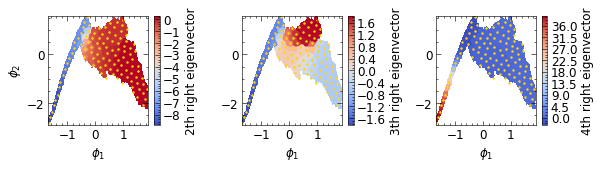

In [35]:
fig, axes = plt.subplots(1, 3, figsize=(8.5, 2.4))
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *tics.T, eigvec[dtraj, i + 1], ax=ax, cmap='coolwarm',
        cbar_label='{}th right eigenvector'.format(i + 2), mask=True)
    ax.scatter(*estimator.cluster_centers.T, s=2, c='gold')
    ax.set_xlabel(r'$\phi_1$')
    ax.set_xlim(np.amin(tics[:,0]),np.amax(tics[:,0]));
    ax.set_ylim(np.amin(tics[:,1]),np.amax(tics[:,1]));
    #ax.set_aspect('equal')
axes[0].set_ylabel(r'$\phi_2$')
fig.tight_layout()
plt.savefig('ticavEigenV.png', dpi=300, bbox_inches='tight')

### PCCA

In [36]:
from deeptime.markov import pcca
nstates = 4
pcca = pcca(bayesian_msm.transition_matrix, nstates)

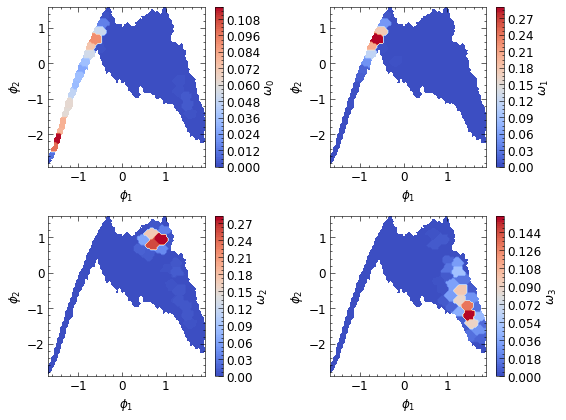

In [37]:
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
for i, ax in enumerate(axes.flat):
    if i < nstates:
        pyemma.plots.plot_contour(
            *tics.T, pcca.metastable_distributions[i][dtraj], ax=ax, cmap='coolwarm', 
            mask=True, method='nearest', cbar_label='$\omega_{}$'.format(i))
        #ax.scatter(*estimator.cluster_centers.T, s=2, c='k')
        ax.set_xlabel(r'$\phi_1$')
        ax.set_ylabel(r'$\phi_2$')
        ax.set_xlim(np.amin(tics[:,0]),np.amax(tics[:,0]));
        ax.set_ylim(np.amin(tics[:,1]),np.amax(tics[:,1]));
fig.tight_layout()
plt.savefig('ticaMetastableD.png', dpi=300, bbox_inches='tight')

In [38]:
gamma = 0
for i, s in enumerate(pcca.sets):
    print('π_{} = {:f}'.format(i, bayesian_msm.stationary_distribution[s].sum()))
    gamma += bayesian_msm.stationary_distribution[s].sum()

print('Gamma =',gamma)

π_0 = 0.000774
π_1 = 0.016078
π_2 = 0.235802
π_3 = 0.747346
Gamma = 0.9999999999999999


#### MFPT from PCCA

In [39]:
#mfpt = np.zeros((nstates, nstates))
#for i in range(nstates):
#    for j in range(nstates):
#        mfpt[i, j] = bayesian_msm.mfpt(
#            pcca.sets[i],
#            pcca.sets[j])
#
#from pandas import DataFrame
#print('MFPT / steps:')
#DataFrame(np.round(mfpt/np.amax(mfpt), decimals=4), index=range(0, nstates), columns=range(0, nstates))

In [40]:
from pandas import DataFrame

mfpt_sample = np.zeros((nstates, nstates))
mfpt_conf_l = np.zeros((nstates, nstates))
mfpt_conf_u = np.zeros((nstates, nstates))

for i in range(nstates):
    for j in range(nstates):
        mfpt_sample[i, j] = bayesian_msm.sample_mean(
            'mfpt',
            pcca.sets[i],
            pcca.sets[j])
        
        mfpt_conf_l[i, j], mfpt_conf_u[i, j] = bayesian_msm.sample_conf(
            'mfpt',
            pcca.sets[i],
            pcca.sets[j])            

DataFrame(np.round(mfpt_sample/np.amax(mfpt_sample), decimals=4), index=range(0, nstates), columns=range(0, nstates))

/home/aaron/Packages/anaconda3/envs/workshop/lib/python3.9/site-packages/pyemma/util/statistics.py:59: UserWarning: confidence interval for constant data is not meaningful
  warnings.warn('confidence interval for constant data is not meaningful')


,0,1,2,3
0,0.0000,0.0002,0.0039,0.0054
1,0.6351,0.0000,0.0033,0.0048
2,0.9932,0.2430,0.0000,0.0025
3,1.0000,0.2499,0.0109,0.0000


In [41]:
rates = np.divide(1,mfpt_sample*Vol,out=np.zeros_like(mfpt_sample),where=(mfpt_sample != 0))
rates_l = np.divide(1,mfpt_conf_l*Vol,out=np.zeros_like(mfpt_sample),where=(mfpt_sample != 0))
rates_u = np.divide(1,mfpt_conf_u*Vol,out=np.zeros_like(mfpt_sample),where=(mfpt_sample != 0))
print('Rates / 1/steps:')
DataFrame(rates, index=range(0, nstates), columns=range(0, nstates))

Rates / 1/steps:


,0,1,2,3
0,0.000000e+00,1.838617e-12,1.078086e-13,7.817357e-14
1,6.665456e-16,0.000000e+00,1.294714e-13,8.894911e-14
2,4.262640e-16,1.742489e-15,0.000000e+00,1.727272e-13
3,4.233464e-16,1.694279e-15,3.888727e-14,0.000000e+00


In [42]:
DataFrame(rates_u, index=range(0, nstates), columns=range(0, nstates))

,0,1,2,3
0,0.000000e+00,1.462517e-12,8.923084e-14,6.500007e-14
1,4.278896e-16,0.000000e+00,1.032921e-13,7.262721e-14
2,2.912279e-16,1.115174e-15,0.000000e+00,1.231437e-13
3,2.834233e-16,1.075998e-15,2.661870e-14,0.000000e+00


In [43]:
DataFrame(rates_l, index=range(0, nstates), columns=range(0, nstates))

,0,1,2,3
0,0.000000e+00,2.372274e-12,1.368155e-13,9.617426e-14
1,1.062521e-15,0.000000e+00,1.670046e-13,1.127342e-13
2,6.036950e-16,2.951861e-15,0.000000e+00,2.375755e-13
3,5.982321e-16,2.855622e-15,5.789943e-14,0.000000e+00


#### PCCA transitions

[ 3 15 37 68]


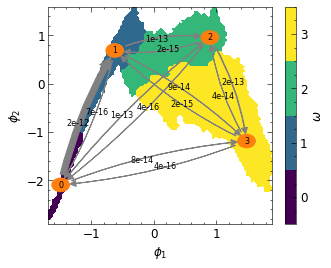

In [44]:
metastable_traj = pcca.assignments[dtraj]
highest_membership = pcca.metastable_distributions.argmax(1)
coarse_state_centers = estimator.cluster_centers[msm.count_model.state_symbols[highest_membership]]
print(highest_membership)

#inverse_mfpt = np.zeros_like(mfpt_sample)
#nz = mfpt.nonzero()
#inverse_mfpt[nz] = 1.0 / mfpt_sample[nz]


fig, ax = plt.subplots(figsize=(5, 4))
_, _, misc = pyemma.plots.plot_state_map(*tics.T, metastable_traj, ax=ax, zorder=-1, nbins=100)
misc['cbar'].set_ticklabels(range(0, nstates))  # set state numbers 1 ... nstates
misc['cbar'].set_label(r'$\omega$')

pyemma.plots.plot_network(
    rates,
    state_scale=0.1,
    state_colors='C1',
    pos=coarse_state_centers,
    figpadding=0.2,
    #arrow_label_format='%.0f',
    arrow_labels=rates,
    arrow_scale=1,
    arrow_curvature=0.85,
    size=8,
    xticks=True,
    yticks=True,
    show_frame=True,
    ax=ax)

ax.set_xlabel(r'$\phi_1$')
ax.set_ylabel(r'$\phi_2$')
ax.set_xlim(np.amin(tics[:,0]),np.amax(tics[:,0]))
ax.set_ylim(np.amin(tics[:,1]),np.amax(tics[:,1]))
#fig.tight_layout()
plt.savefig('pcca.png', dpi=300, bbox_inches='tight')

In [45]:
print(CVdim,"CVs. Number of states:",estimator.cluster_centers.shape[0])

17 CVs. Number of states: 105
